<a href="https://colab.research.google.com/github/pri-nitta/FIAP_IA/blob/main/Redes_Advers%C3%A1rias_Generativas_(GANs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.__version__

'2.17.1'

In [8]:
import os
import glob #gerar gif
import imageio #gerar gif
import matplotlib.pyplot as plt # gerar gráficos
import numpy as np # trabalhar com arrays
import PIL # manipular imagens
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
import time

from IPython import display

In [3]:
(train_images, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') # definindo o tamanho da imagem (28x28) com 1 canal de cinza / astype para ocupar menos espaço na memória
train_images = (train_images - 127.5) / 127.5 # normalizando a imagem para -1, 1

In [5]:
BUFFER_SIZE = 60000 # tamanho do conjunto de dados, volume de processamento das imagens
BATCH_SIZE = 256 # quantidade de pixels que varia, numero de pixels aceitos

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE) #conjunto de dados + batch para normalizar os pixels

In [9]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) # entrada de um ruído randomico (a primeira imagem vai ter a profundidade 256 de 7*7)
  model.add(layers.BatchNormalization()) # técnica que normaliza (z-score) os pesos de uma camada para a próxima camada # limita os valores em um máximo e um mínimo (ajuda a ficar com um valor estável)
  model.add(layers.LeakyReLU())          # função de ativação onde os valores negativos sejam transmitidos (atribui um valor pequeno para aproximar o valor à 0), considera os valores negativos

  model.add(layers.Reshape((7,7,256))) #para deixar no formato de imagem
  assert model.output_shape == (None, 7, 7, 256) # None é o batch size

  #Conv2DTranspose: camada de convolução para aumentar a imagem #padding aplicar bordas de zeros para ajudar a aumentar a imagem
  model.add(layers.Conv2DTranspose(128,(5, 5), strides=(1,1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64,(5, 5), strides=(2,2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1,(5, 5), strides=(2,2), padding='same', use_bias=False, activation='tanh')) #imagem final da imagem gerada canal 1
  assert model.output_shape == (None, 28, 28, 1)

  return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


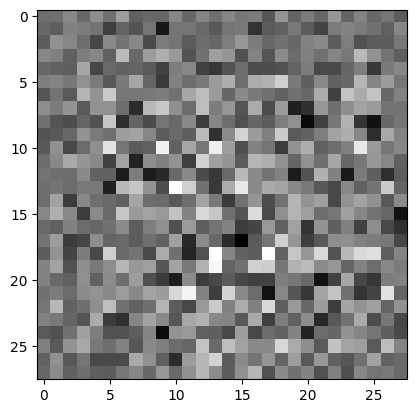

In [10]:

generator = make_generator_model()

noise = tf.random.normal([1, 100]) #ruído aleatório
generator_image = generator(noise, training=False) # entrada inicial

plt.imshow(generator_image[0, :, :, 0], cmap='gray')

In [11]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2,2), padding='same', input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

  #comparar com imagens reais

In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generator_image) # valor positivo, imagem real. Valor negativo, imagem fake.
print(decision)

tf.Tensor([[3.3361983e-05]], shape=(1, 1), dtype=float32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:

# configurando a função de custo (loss function)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False) # crio uma função loss (para 0 e 1, mais prox de 1 é real)

In [14]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output) # dado real # 1 verdadeiro
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # dado fake # 0 falso
  total_loss = real_loss + fake_loss # faz a comparação
  return total_loss

In [15]:
# avaliar fake gerado
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output ), fake_output) # dado fake apenas

In [16]:
# definindo o otimizador da função de custo Adam
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [17]:
# para salvar o modelo
checkpoint_dir = './training_checkpoints' #diretório para salvar pontos específicos de rede
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                               discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

In [18]:
EPOCHS = 35
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [19]:
@tf.function
def train_step(images):
    # Gerando ruído aleatório para a entrada do gerador
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # Usando GradientTape para registrar as operações para o cálculo do gradiente
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Gerando imagens usando o gerador
        generated_images = generator(noise, training=True)

        # Calculando as saídas reais e falsas usando o discriminador
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculando as perdas do gerador e do discriminador
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculando os gradientes em relação aos parâmetros do gerador e do discriminador
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Aplicando os gradientes usando otimizadores separados para gerador e discriminador
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [20]:
def train(dataset, epochs):
  # Itera sobre o número especificado de épocas
  for epoch in range(epochs):
    start = time.time()  # Marca o início do tempo para esta época

    # Itera sobre os lotes de imagens no conjunto de dados
    for image_batch in dataset:
      train_step(image_batch)  # Chama a função de treinamento definida anteriormente para um lote de imagens

    # Produz imagens para o GIF enquanto treina
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Salva o modelo a cada 15 épocas
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    # Imprime o tempo decorrido para a época atual
    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Gera e salva imagens após a última época
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

In [21]:
# Função para gerar e salvar imagens usando o modelo treinado

def generate_and_save_images(model, epoch, test_input):
  # Observação: `training` é definido como False.
  # Isso é para que todas as camadas funcionem no modo de inferência (batchnorm).
  predictions = model(test_input, training=False)  # Modo de treinamento False para o gerador criar as imagens

  # Configuração da figura para exibir as imagens geradas
  fig = plt.figure(figsize=(4, 4))

  # Itera sobre as previsões geradas
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      # Ajusta a escala e exibe a imagem gerada
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')  # Desliga as coordenadas do eixo

  # Salva a imagem gerada
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()  # Exibe a imagem gerada no momento

In [ ]:
train(train_dataset, EPOCHS)